In the first notebook, we accumulated useful features from multiple csv files into one training set and aggregated some functions, as well as remove some outliers from our dataset amongst other actions. In this notebook, we will try to visualise our big dataframe (time-series data) to see if we can infer some more information from it, as well as engineer further features and apply some more techniques typically applied to time series data that might help us infer information regarding the test set.

Again, like in the previous notebook, I want to give kudos to a few of the following notebooks from whom I have used as blueprints to my own solution. I would recommend also checkiing out their notebooks and upvoting in Kaggle if you have found it useful as I have done.

-  https://www.kaggle.com/dlarionov/feature-engineering-xgboost
-  https://www.kaggle.com/kyakovlev/1st-place-solution-part-1-hands-on-data
-  https://www.kaggle.com/dimitreoliveira/model-stacking-feature-engineering-and-eda

Author: Steven Vuong <br>
Last Updated: 25/04/2020

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import warnings

# Visualisation Libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Styling Preferences
%matplotlib inline
sns.set(style="darkgrid")
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
% cd '../gdrive/My Drive/self_teach/udacity_ml_eng_nanodegree'

/gdrive/My Drive/self_teach/udacity_ml_eng_nanodegree


In [4]:
# Load in dataset, picking up where we left off in pt-1.
# Again, we will cast to int16 and float32 to save some memory which will be needed
# further down in processing our dataset.
train = pd.read_csv('./data/output/processed_data_pt1.csv',dtype={
                        'date_block_num': 'int16', 
                        'city_code': 'int16', 
                        'item_name_code': 'int16', 
                        'item_category_type_code': 'int16', 
                        'item_category_subtype_code': 'int16', 
                        'shop_id': 'int16', 
                        'item_category_id': 'int16',
                        'item_id': 'int16',
                        'sum_item_price': 'float32',
                        'mean_item_price': 'float32',
                        'sum_item_count': 'int16',
                        'mean_item_count': 'float32', 
                        'transactions': 'int16'}
                   )

# Deal with unnamed if exists (index)
if "Unnamed: 0" in train.columns:
    train = train.drop(("Unnamed: 0"), axis=1)
    
print(len(train))
train.head()

7282800


,date_block_num,item_category_type_code,item_category_subtype_code,item_name_code,city_code,shop_id,item_category_id,item_id,sum_item_price,mean_item_price,sum_item_count,mean_item_count,transactions
0,0,0,9,365,0,2,2,5572,10730.00,1532.86,9,1.29,7
1,0,0,9,365,1,3,2,5572,4770.00,1590.00,3,1.00,3
2,0,0,9,365,2,4,2,5572,4570.00,1523.33,3,1.00,3
3,0,0,9,365,4,6,2,5572,11130.00,1590.00,8,1.14,7
4,0,0,9,365,4,7,2,5572,11030.00,1575.71,8,1.14,7


In [5]:
# Extract time based features. Make a separate column for Year and Month
train['year'] = train['date_block_num'].apply(lambda x: ((x//12) + 2013))
train['month'] = train['date_block_num'].apply(lambda x: (x % 12))

train.head()

,date_block_num,item_category_type_code,item_category_subtype_code,item_name_code,city_code,shop_id,item_category_id,item_id,sum_item_price,mean_item_price,sum_item_count,mean_item_count,transactions,year,month
0,0,0,9,365,0,2,2,5572,10730.00,1532.86,9,1.29,7,2013,0
1,0,0,9,365,1,3,2,5572,4770.00,1590.00,3,1.00,3,2013,0
2,0,0,9,365,2,4,2,5572,4570.00,1523.33,3,1.00,3,2013,0
3,0,0,9,365,4,6,2,5572,11130.00,1590.00,8,1.14,7,2013,0
4,0,0,9,365,4,7,2,5572,11030.00,1575.71,8,1.14,7,2013,0


We will try to visualise trends in our data, which may be seasonal or dependent on the yearr. Ultimately, we want to predict the "sum_item_count" for the following month within our data, which might vary by month, item category or shop id. Below we will look at how some some of our features perform by looking at monthly mean as well as monthly sum.

In [0]:
# Grouping data to plot

# Group by month
gp_month_mean = train.groupby(['month'], as_index=False)['sum_item_count'].mean()
gp_month_sum = train.groupby(['month'], as_index=False)['sum_item_count'].sum()

# Group by item_category 
gp_category_mean = train.groupby(['item_category_id'], as_index=False)['sum_item_count'].mean()
gp_category_sum = train.groupby(['item_category_id'], as_index=False)['sum_item_count'].sum()

# Group by shop_id
gp_shop_mean = train.groupby(['shop_id'], as_index=False)['sum_item_count'].mean()
gp_shop_sum = train.groupby(['shop_id'], as_index=False)['sum_item_count'].sum()

In [0]:
# Group by item name code
gp_item_name_code_mean = train.groupby(['item_name_code'], as_index=False)['sum_item_count'].mean()
gp_item_name_code_sum =  train.groupby(['item_name_code'], as_index=False)['sum_item_count'].sum()

# Group by city code 
gp_city_code_mean = train.groupby(['city_code'], as_index=False)['sum_item_count'].mean()
gp_city_code_sum =  train.groupby(['city_code'], as_index=False)['sum_item_count'].sum()

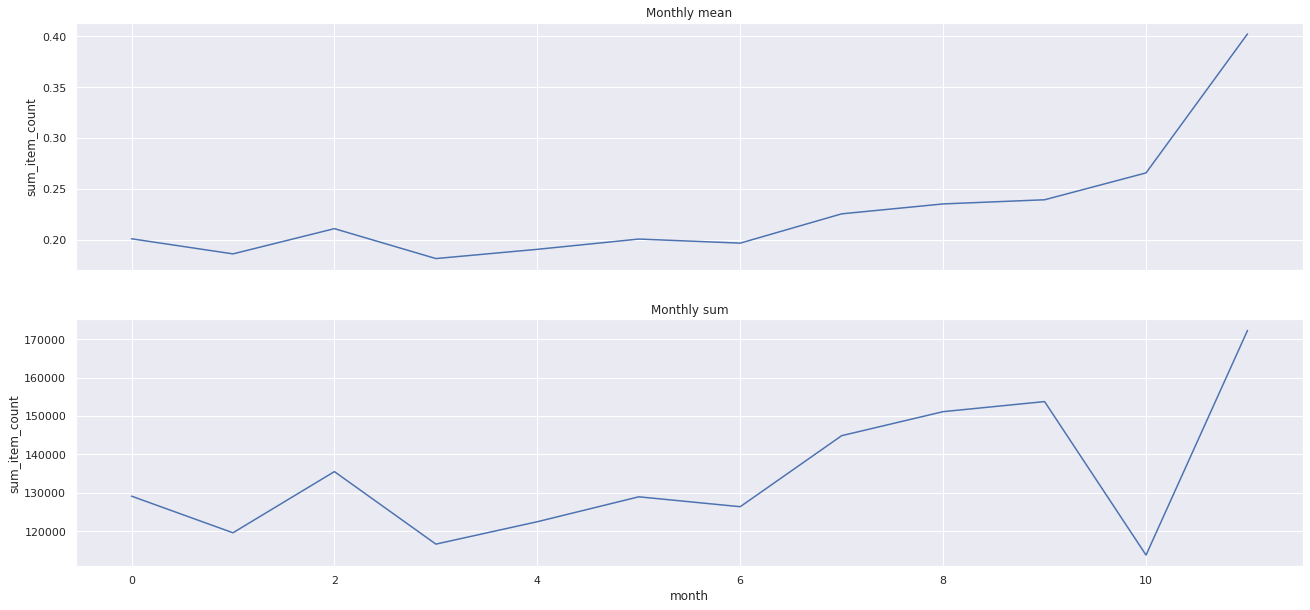

In [8]:
# Plot item count mean and sum against month
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.lineplot(x="month", y="sum_item_count", data=gp_month_mean, ax=axes[0]).set_title("Monthly mean")
sns.lineplot(x="month", y="sum_item_count", data=gp_month_sum, ax=axes[1]).set_title("Monthly sum")
plt.show()

It seems there is an increase in sales towards the end of the year, and a lull in the mid months frrom the monthly mean. From the monthly sum, there is a dip on the 10th montth and dip on the 3rd.

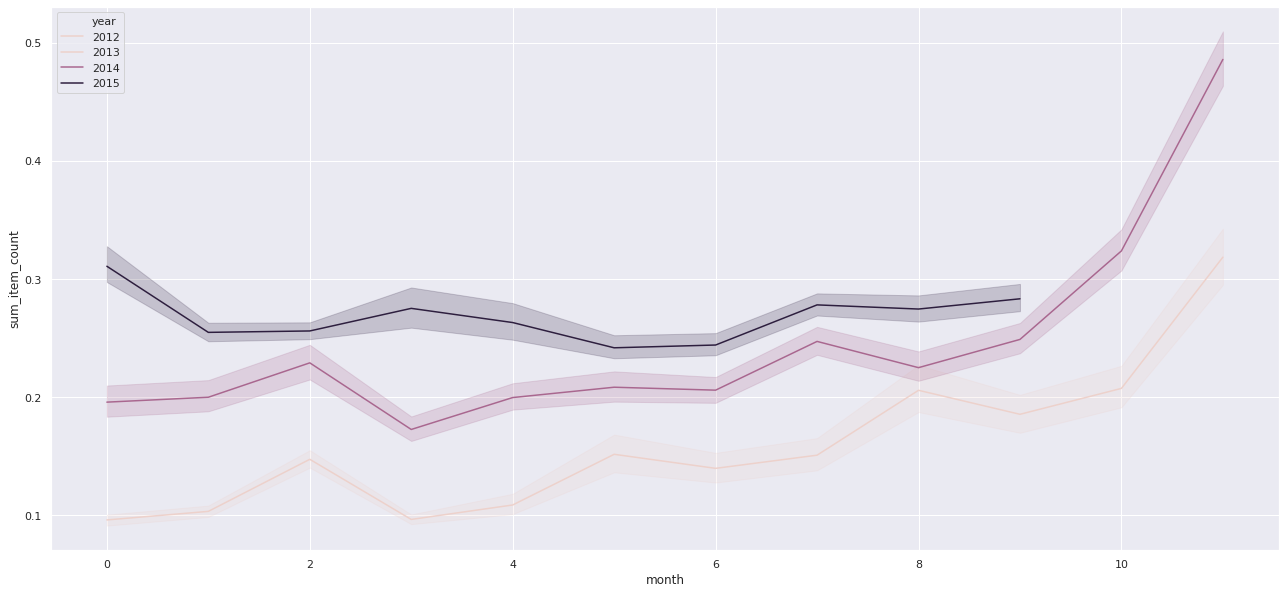

In [9]:
# Also plot the item counts by year
f, axes = plt.subplots(1, 1, figsize=(22, 10), sharex=True)
sns.lineplot(x="month", y="sum_item_count", hue="year",data=train)
plt.show()

It seems sales are gettitng better year on year; with 2014 outperforming 2013 and 2015 outperforming 2014. We have 2012 in our key which is interesting. Here we can also see seasonal trends in our monthly data also, noticing dips in month 3, which does not occur for 2015. The data for 2015 is incomplete so stops at month 9, although we expect it to rise in accordance with trends in 2013 and 2014.

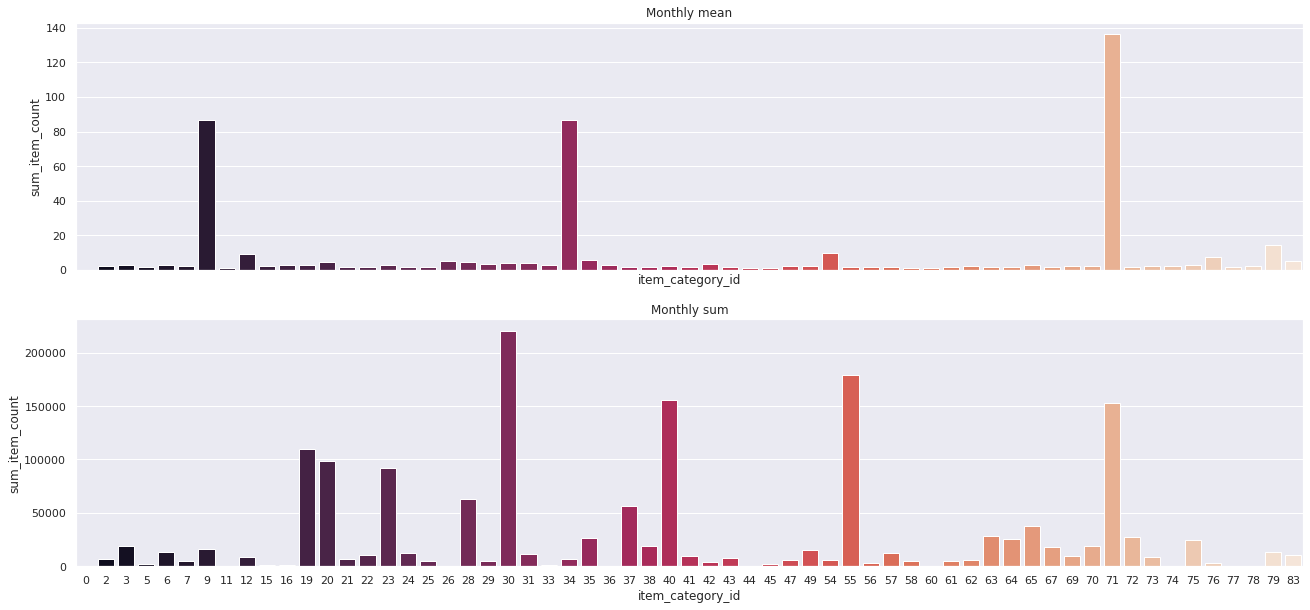

In [10]:
# We can also plot by item category id
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="item_category_id", y="sum_item_count", data=gp_category_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="item_category_id", y="sum_item_count", data=gp_category_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
plt.show()

It appears only a few items sell very well in contrast to other items. The monthly sum values differ from monthly mean, other than category_id 71.

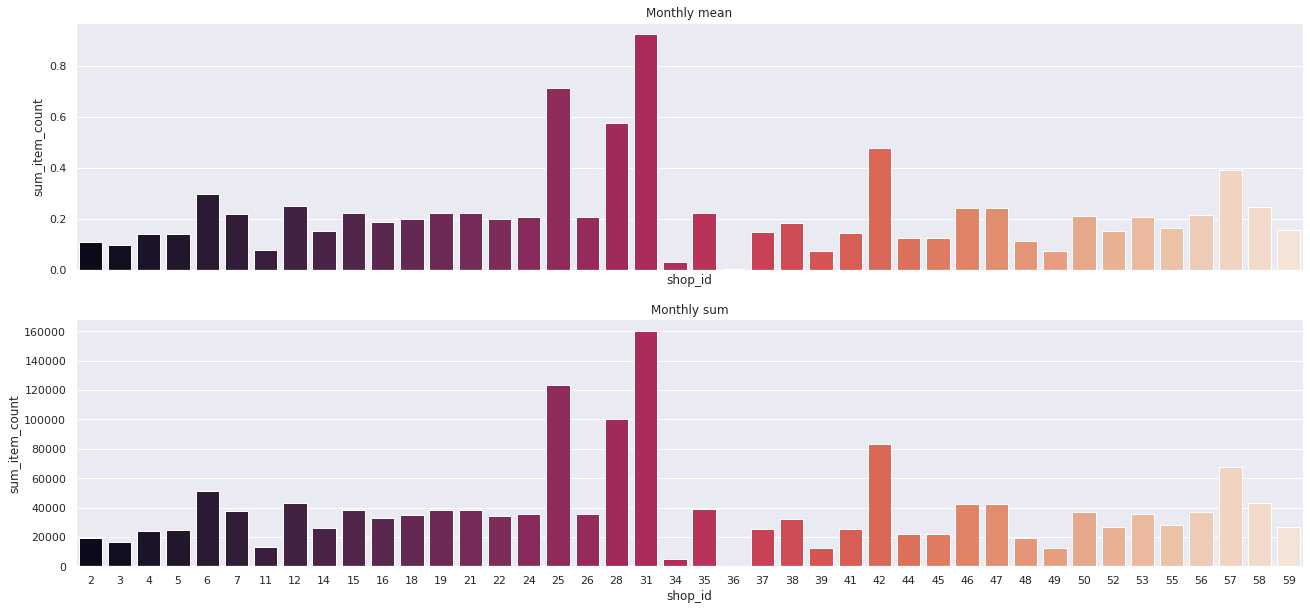

In [11]:
# We can also plot by shop id
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="shop_id", y="sum_item_count", data=gp_shop_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="shop_id", y="sum_item_count", data=gp_shop_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
plt.show()

There are about 4 shops that sell way above the others, which have a similar sell amount. There may be other reasons for this such as shop location or size which could be worth looking into.

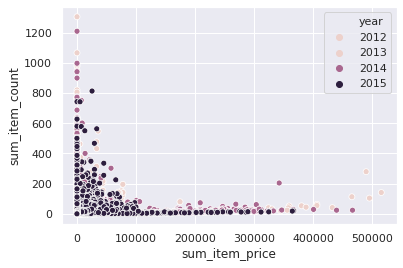

In [12]:
# And now plot the sum item count against the sum item price

sns.scatterplot(x="sum_item_price", y="sum_item_count", hue="year", data=train)
plt.show()

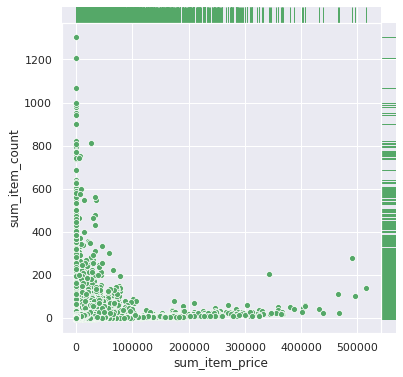

In [13]:
# Also plot jointgrid to see density
grid = sns.JointGrid(x="sum_item_price", y="sum_item_count", data=train, space=0, height=6, ratio=20)
grid.plot_joint(sns.scatterplot, color="g")
grid.plot_marginals(sns.rugplot, height=1, color="g")

plt.show()

The jointplot grid and scattterplot reveals (expectedly) that a high item price typically has a low number of item sales count and a low item price typically has a high item count sales. This is seen from the points hugging the x and y axis, with several points clustered around low item coount and low item price, thus indicating a negative correlation between item price and count as one might expect. This could be useful information in helping to target a particular item count or price discounts etc.. at a business level. For our model, the item price will be a feature in helping to determine the item count.

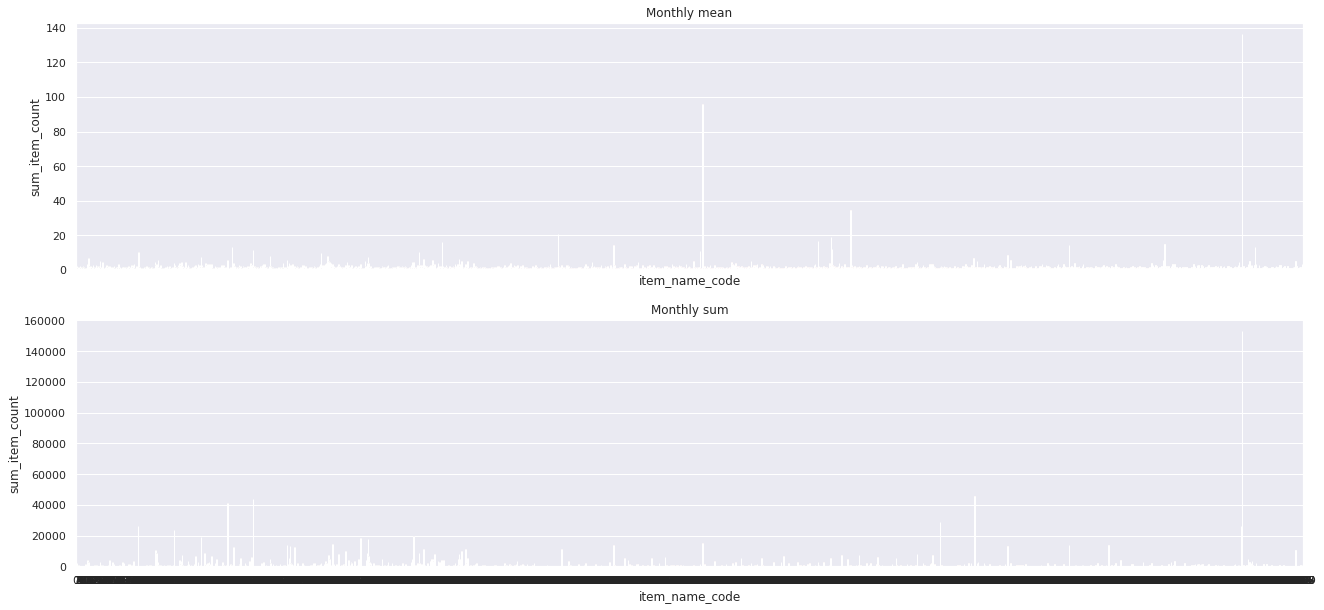

In [14]:
# We can also plot by item name code
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="item_name_code", y="sum_item_count", data=gp_item_name_code_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="item_name_code", y="sum_item_count", data=gp_item_name_code_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
plt.show()

It seems there are a only a few, perhaps 2 item name codes that certainly outstrips the rest and are very popular in sales.

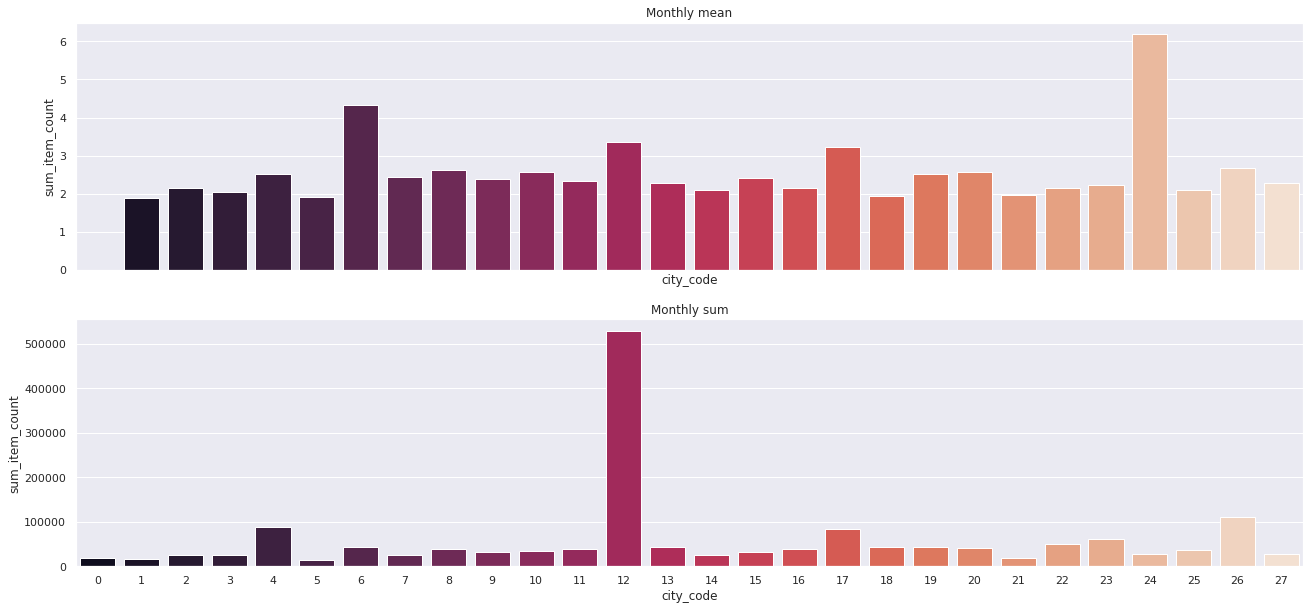

In [15]:
# Plot by the city code to see how this factor plays a part
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="city_code", y="sum_item_count", data=gp_city_code_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="city_code", y="sum_item_count", data=gp_city_code_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
plt.show()

This seems really interesting, it looks like there are two cities which really stand out and do well in terms of item count sales for the brand. Perhaps there is a correlation here with the shop id.

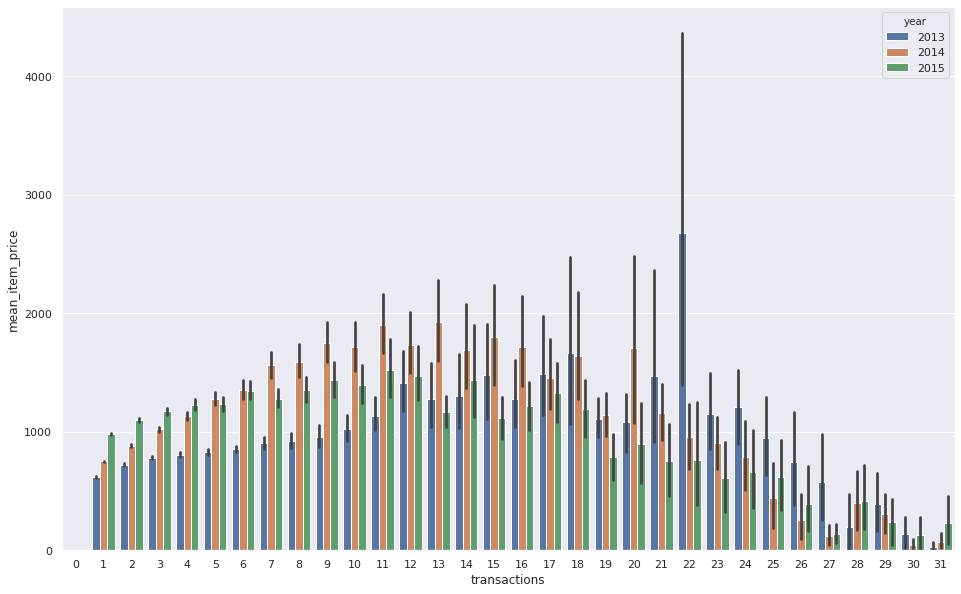

In [16]:
# Mean item price vs transactions
fig, ax = plt.subplots(1,1,figsize=(16,10))
sns.barplot(x="transactions", y="mean_item_price", hue="year", data=train)
plt.show()

It appears a very large number of transactions occurred for 2013, whereas the rest of the year looks steady for the mean item price across each year.

As this is a forecasting problm, we will create our target (Y) column "sum_item_cnt_next_month" which is the item count of the next month for a given item. To reiterate, the goal is to predict the item count for the following month for items in the test set.

In [17]:
# Shift item count for next month
train['sum_item_cnt_next_month'] = train.sort_values('date_block_num').groupby(['shop_id', 'sum_item_count'])['sum_item_count'].shift(-1)
train.head()

,date_block_num,item_category_type_code,item_category_subtype_code,item_name_code,city_code,shop_id,item_category_id,item_id,sum_item_price,mean_item_price,sum_item_count,mean_item_count,transactions,year,month,sum_item_cnt_next_month
0,0,0,9,365,0,2,2,5572,10730.00,1532.86,9,1.29,7,2013,0,9.00
1,0,0,9,365,1,3,2,5572,4770.00,1590.00,3,1.00,3,2013,0,3.00
2,0,0,9,365,2,4,2,5572,4570.00,1523.33,3,1.00,3,2013,0,3.00
3,0,0,9,365,4,6,2,5572,11130.00,1590.00,8,1.14,7,2013,0,8.00
4,0,0,9,365,4,7,2,5572,11030.00,1575.71,8,1.14,7,2013,0,8.00


What could also be interesting as a feature is the item price per unit, we will create a column for this and have it as another input feature to our model.

In [18]:
# Create a column with item price per unit
train['item_price_unit'] = train['sum_item_price'] // train['sum_item_count']

# Replace inf with Nan (occurs when division by zero)
train['item_price_unit'] = train['item_price_unit'].replace([np.inf, -np.inf], np.nan)
# fillna witth 0
train['item_price_unit'].fillna(0, inplace=True)

print(train['item_price_unit'].max()) # Sanity check
train.head()

94970.0


,date_block_num,item_category_type_code,item_category_subtype_code,item_name_code,city_code,shop_id,item_category_id,item_id,sum_item_price,mean_item_price,sum_item_count,mean_item_count,transactions,year,month,sum_item_cnt_next_month,item_price_unit
0,0,0,9,365,0,2,2,5572,10730.00,1532.86,9,1.29,7,2013,0,9.00,1192.00
1,0,0,9,365,1,3,2,5572,4770.00,1590.00,3,1.00,3,2013,0,3.00,1590.00
2,0,0,9,365,2,4,2,5572,4570.00,1523.33,3,1.00,3,2013,0,3.00,1523.00
3,0,0,9,365,4,6,2,5572,11130.00,1590.00,8,1.14,7,2013,0,8.00,1391.00
4,0,0,9,365,4,7,2,5572,11030.00,1575.71,8,1.14,7,2013,0,8.00,1378.00


For each item id, we can also investigate the maximum and minimum item price , making this a feature of our dataset also. This allows us to then see for each row, how much an item deviates from the maximum or minimum item price. Another possibly interesting feature our model may use.

In [19]:
# Group items and return minimum and maximum price for each item id
gp_item_price = train.sort_values('date_block_num').groupby(['item_id'], as_index=False).agg({'sum_item_price':[np.min, np.max]})
gp_item_price.columns = ['item_id', 'hist_min_item_price', 'hist_max_item_price']

gp_item_price.head()

,item_id,hist_min_item_price,hist_max_item_price
0,30,0.00,9975.00
1,31,0.00,10938.33
2,32,0.00,8027.00
3,33,0.00,2994.00
4,38,0.00,4798.00


In [20]:
# Merge into main df
train = pd.merge(train, gp_item_price, on='item_id', how='left')
train.head()

,date_block_num,item_category_type_code,item_category_subtype_code,item_name_code,city_code,shop_id,item_category_id,item_id,sum_item_price,mean_item_price,sum_item_count,mean_item_count,transactions,year,month,sum_item_cnt_next_month,item_price_unit,hist_min_item_price,hist_max_item_price
0,0,0,9,365,0,2,2,5572,10730.00,1532.86,9,1.29,7,2013,0,9.00,1192.00,0.00,18979.50
1,0,0,9,365,1,3,2,5572,4770.00,1590.00,3,1.00,3,2013,0,3.00,1590.00,0.00,18979.50
2,0,0,9,365,2,4,2,5572,4570.00,1523.33,3,1.00,3,2013,0,3.00,1523.00,0.00,18979.50
3,0,0,9,365,4,6,2,5572,11130.00,1590.00,8,1.14,7,2013,0,8.00,1391.00,0.00,18979.50
4,0,0,9,365,4,7,2,5572,11030.00,1575.71,8,1.14,7,2013,0,8.00,1378.00,0.00,18979.50


In [21]:
# Aggregate how a given item price has changed from it's minimum and maximum prices
train['price_increase'] = train['sum_item_price'] - train['hist_min_item_price']
train['price_decrease'] = train['hist_max_item_price'] - train['sum_item_price']
train.head()

,date_block_num,item_category_type_code,item_category_subtype_code,item_name_code,city_code,shop_id,item_category_id,item_id,sum_item_price,mean_item_price,sum_item_count,mean_item_count,transactions,year,month,sum_item_cnt_next_month,item_price_unit,hist_min_item_price,hist_max_item_price,price_increase,price_decrease
0,0,0,9,365,0,2,2,5572,10730.00,1532.86,9,1.29,7,2013,0,9.00,1192.00,0.00,18979.50,10730.00,8249.50
1,0,0,9,365,1,3,2,5572,4770.00,1590.00,3,1.00,3,2013,0,3.00,1590.00,0.00,18979.50,4770.00,14209.50
2,0,0,9,365,2,4,2,5572,4570.00,1523.33,3,1.00,3,2013,0,3.00,1523.00,0.00,18979.50,4570.00,14409.50
3,0,0,9,365,4,6,2,5572,11130.00,1590.00,8,1.14,7,2013,0,8.00,1391.00,0.00,18979.50,11130.00,7849.50
4,0,0,9,365,4,7,2,5572,11030.00,1575.71,8,1.14,7,2013,0,8.00,1378.00,0.00,18979.50,11030.00,7949.50


A powerful technique when playing with time series data is a rolling window. Here, we will create a 3 month rolling window for our features and calculate summary statistics (max, min, mean and standard deviation) of the sum_item_count and appending these features as columns to our dataframe. 3 months has been chosen as it is long enough to capture a season, hoping to capture seasonal trends without being too long to make computation detrimental or omit more data (if we had data dating back further, we could increase the length of the window duration to capture longer trends. However, we only have data from early 2013 to late 2015).

This has the advantages of also helping to assess the stability of our model and gauge instabilities in our data, which may be useful to our model as well as time invariance.


Some more reading about rolling windows can be found online, one resource I quite liked was: https://www.mathworks.com/help/econ/rolling-window-estimation-of-state-space-models.html 

Another useful notebook introducing some time series models: https://www.kaggle.com/jagangupta/time-series-basics-exploring-traditional-ts/data#Single-series.

In [0]:
# Initialise rolling window parameters
window_size = 3
min_periods_len = 1

# Minimum value rolling window
f_min = lambda x: x.rolling(window=window_size, min_periods=min_periods_len).min()

# Maximum value rolling window
f_max = lambda x: x.rolling(window=window_size, min_periods=min_periods_len).max()

# Mean value rolling window
f_mean = lambda x: x.rolling(window=window_size, min_periods=min_periods_len).mean()

# Standard deviation rolling window
f_std = lambda x: x.rolling(window=window_size, min_periods=min_periods_len).std()

In [0]:
# Create lists of functions and names of features to append
function_list = [f_min, f_max, f_mean, f_std]
function_name = ['min', 'max', 'mean', 'std']

# Loop through functions list, groupby a number of our categories and apply corresponding functions
for i in range(len(function_list)):
    train[('item_cnt_%s' % function_name[i])] = train.sort_values('date_block_num').groupby([
        'shop_id', 
        'item_category_id', 
        'item_id', # Just compute primary category group bys
        # 'city_code', # Too long to compute; in an ideal world we would
        # 'item_category_type_code',
        # 'item_category_subtype_code',
        # 'item_name_code'
    ])['sum_item_count'].apply(function_list[i])

# Fill the empty std features with 0
train['item_cnt_std'].fillna(0, inplace=True)

In [24]:
train.head()

,date_block_num,item_category_type_code,item_category_subtype_code,item_name_code,city_code,shop_id,item_category_id,item_id,sum_item_price,mean_item_price,sum_item_count,mean_item_count,transactions,year,month,sum_item_cnt_next_month,item_price_unit,hist_min_item_price,hist_max_item_price,price_increase,price_decrease,item_cnt_min,item_cnt_max,item_cnt_mean,item_cnt_std
0,0,0,9,365,0,2,2,5572,10730.00,1532.86,9,1.29,7,2013,0,9.00,1192.00,0.00,18979.50,10730.00,8249.50,9.00,9.00,9.00,0.00
1,0,0,9,365,1,3,2,5572,4770.00,1590.00,3,1.00,3,2013,0,3.00,1590.00,0.00,18979.50,4770.00,14209.50,3.00,3.00,3.00,0.00
2,0,0,9,365,2,4,2,5572,4570.00,1523.33,3,1.00,3,2013,0,3.00,1523.00,0.00,18979.50,4570.00,14409.50,3.00,3.00,3.00,0.00
3,0,0,9,365,4,6,2,5572,11130.00,1590.00,8,1.14,7,2013,0,8.00,1391.00,0.00,18979.50,11130.00,7849.50,8.00,8.00,8.00,0.00
4,0,0,9,365,4,7,2,5572,11030.00,1575.71,8,1.14,7,2013,0,8.00,1378.00,0.00,18979.50,11030.00,7949.50,8.00,8.00,8.00,0.00


In [25]:
train.date_block_num.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33],
      dtype=int16)

Lag features are essentially variables carried over from prior time steps that may be useful in calculating the future time step. This is a classical approach of turning our time-series problem into one that more closely aligns with a supervised learning problem, so phrasing the problem in a different manner. In line with the duration of our rolling window, we will use 3 months of lag based features to capture a season.

References:
-  https://machinelearningmastery.com/basic-feature-engineering-time-series-data-python/
-  https://www.analyticsvidhya.com/blog/2019/12/6-powerful-feature-engineering-techniques-time-series/

In [0]:
# Create list of lag features (we will use up to 3 months)
lag_list = [1, 2, 3]

# Loop through lag list, groupby categories and create column for corresponding shifted lag
for lag in lag_list:
    ft_name = ('item_cnt_shifted%s' % lag)
    train[ft_name] = train.sort_values('date_block_num').groupby([
        'shop_id', 
        'item_category_id', 
        'item_id',
        # 'city_code', # Same principle applies
        # 'item_category_type_code',
        # 'item_category_subtype_code',
        # 'item_name_code'
    ])['sum_item_count'].shift(lag)
    
    # Fill the empty shifted features with 0
    train[ft_name].fillna(0, inplace=True)

In [27]:
train.date_block_num.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33],
      dtype=int16)

In [28]:
train.head()

,date_block_num,item_category_type_code,item_category_subtype_code,item_name_code,city_code,shop_id,item_category_id,item_id,sum_item_price,mean_item_price,sum_item_count,mean_item_count,transactions,year,month,sum_item_cnt_next_month,item_price_unit,hist_min_item_price,hist_max_item_price,price_increase,price_decrease,item_cnt_min,item_cnt_max,item_cnt_mean,item_cnt_std,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3
0,0,0,9,365,0,2,2,5572,10730.00,1532.86,9,1.29,7,2013,0,9.00,1192.00,0.00,18979.50,10730.00,8249.50,9.00,9.00,9.00,0.00,0.00,0.00,0.00
1,0,0,9,365,1,3,2,5572,4770.00,1590.00,3,1.00,3,2013,0,3.00,1590.00,0.00,18979.50,4770.00,14209.50,3.00,3.00,3.00,0.00,0.00,0.00,0.00
2,0,0,9,365,2,4,2,5572,4570.00,1523.33,3,1.00,3,2013,0,3.00,1523.00,0.00,18979.50,4570.00,14409.50,3.00,3.00,3.00,0.00,0.00,0.00,0.00
3,0,0,9,365,4,6,2,5572,11130.00,1590.00,8,1.14,7,2013,0,8.00,1391.00,0.00,18979.50,11130.00,7849.50,8.00,8.00,8.00,0.00,0.00,0.00,0.00
4,0,0,9,365,4,7,2,5572,11030.00,1575.71,8,1.14,7,2013,0,8.00,1378.00,0.00,18979.50,11030.00,7949.50,8.00,8.00,8.00,0.00,0.00,0.00,0.00


And with the lag based features; we can see how the item count for any given item has changed over the lag window duration (3 months) and thus capture a 'trend'.

In [0]:
# Initialise column of item trend
train['item_trend'] = train['sum_item_count']

# Compare item against lag features to capture trend
for lag in lag_list:
    ft_name = ('item_cnt_shifted%s' % lag)
    train['item_trend'] -= train[ft_name]

# Normalise
train['item_trend'] /= len(lag_list) + 1

In [30]:
train.head()

,date_block_num,item_category_type_code,item_category_subtype_code,item_name_code,city_code,shop_id,item_category_id,item_id,sum_item_price,mean_item_price,sum_item_count,mean_item_count,transactions,year,month,sum_item_cnt_next_month,item_price_unit,hist_min_item_price,hist_max_item_price,price_increase,price_decrease,item_cnt_min,item_cnt_max,item_cnt_mean,item_cnt_std,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3,item_trend
0,0,0,9,365,0,2,2,5572,10730.00,1532.86,9,1.29,7,2013,0,9.00,1192.00,0.00,18979.50,10730.00,8249.50,9.00,9.00,9.00,0.00,0.00,0.00,0.00,2.25
1,0,0,9,365,1,3,2,5572,4770.00,1590.00,3,1.00,3,2013,0,3.00,1590.00,0.00,18979.50,4770.00,14209.50,3.00,3.00,3.00,0.00,0.00,0.00,0.00,0.75
2,0,0,9,365,2,4,2,5572,4570.00,1523.33,3,1.00,3,2013,0,3.00,1523.00,0.00,18979.50,4570.00,14409.50,3.00,3.00,3.00,0.00,0.00,0.00,0.00,0.75
3,0,0,9,365,4,6,2,5572,11130.00,1590.00,8,1.14,7,2013,0,8.00,1391.00,0.00,18979.50,11130.00,7849.50,8.00,8.00,8.00,0.00,0.00,0.00,0.00,2.00
4,0,0,9,365,4,7,2,5572,11030.00,1575.71,8,1.14,7,2013,0,8.00,1378.00,0.00,18979.50,11030.00,7949.50,8.00,8.00,8.00,0.00,0.00,0.00,0.00,2.00


In [31]:
train.date_block_num.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33],
      dtype=int16)

In [32]:
train.describe()

,date_block_num,item_category_type_code,item_category_subtype_code,item_name_code,city_code,shop_id,item_category_id,item_id,sum_item_price,mean_item_price,sum_item_count,mean_item_count,transactions,year,month,sum_item_cnt_next_month,item_price_unit,hist_min_item_price,hist_max_item_price,price_increase,price_decrease,item_cnt_min,item_cnt_max,item_cnt_mean,item_cnt_std,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3,item_trend
count,7282800.00,7282800.00,7282800.00,7282800.00,7282800.00,7282800.00,7282800.00,7282800.00,7282800.00,7282800.00,7282800.00,7282800.00,7282800.00,7282800.00,7282800.00,7279534.00,7282800.00,7282800.00,7282800.00,7282800.00,7282800.00,7282800.00,7282800.00,7282800.00,7282800.00,7282800.00,7282800.00,7282800.00,7282800.00
mean,16.50,0.56,1.34,58.02,1.17,31.67,3.50,11019.40,173.25,75.01,0.22,0.09,0.17,2013.94,5.21,0.19,71.16,0.00,5791.18,173.25,5627.37,0.17,0.33,0.24,0.09,0.20,0.18,0.16,-0.08
std,9.81,2.04,6.26,235.35,4.40,17.53,12.74,6252.63,2087.32,509.42,3.20,0.45,0.87,0.80,3.32,1.29,488.50,0.00,13886.88,2087.32,13296.43,2.52,4.24,3.17,1.41,3.16,3.12,3.10,1.60
min,0.00,0.00,0.00,0.00,0.00,2.00,0.00,30.00,0.00,0.00,-4.00,-2.00,0.00,2013.00,0.00,-2.00,-33490.00,0.00,0.00,0.00,0.00,-4.00,-2.00,-2.00,0.00,-4.00,-4.00,-4.00,-636.00
25%,8.00,0.00,0.00,0.00,0.00,16.00,0.00,5381.50,0.00,0.00,0.00,0.00,0.00,2013.00,2.00,0.00,0.00,0.00,799.00,0.00,796.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,16.50,0.00,0.00,0.00,0.00,34.50,0.00,11203.00,0.00,0.00,0.00,0.00,0.00,2014.00,5.00,0.00,0.00,0.00,2197.00,0.00,2097.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,25.00,0.00,0.00,0.00,0.00,47.00,0.00,16071.50,0.00,0.00,0.00,0.00,0.00,2015.00,8.00,0.00,0.00,0.00,5593.00,0.00,5489.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,33.00,13.00,47.00,1589.00,27.00,59.00,83.00,22167.00,515573.59,42990.00,1305.00,500.00,31.00,2015.00,11.00,764.00,94970.00,0.00,515573.59,515573.59,515573.59,978.00,1305.00,1090.67,571.34,1305.00,1305.00,1305.00,203.25


In [0]:
# Save as csv
train.to_csv('./data/output/processed_data_pt2.csv', index=False, header=True)

Lessons Learnt:
-  Test the data and check as many things as possible with training our model in mind and what we might be submitting at the very end -> organise & ready for submission.